In [88]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from tqdm import tqdm
import datetime

In [89]:
working_path = "/home/watts/lal/Kaggle/lung_cancer/"

In [90]:
train = pd.read_csv(working_path+'cache/my_train.csv', sep=',')
test = pd.read_csv(working_path+'cache/my_test.csv', sep=',')
target = 'output'
idcol = 'id'
scan_folder = 'scan_folder'

In [91]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds
#                           ,show_progress=False
                         )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['output'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['output'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['output'], dtrain_predprob)
    print "LogLoss Score (Train): %f" % metrics.log_loss(dtrain['output'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
def modelfit2(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds
#                           ,show_progress=False
                         )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['output'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['output'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['output'], dtrain_predprob)
    print "LogLoss Score (Train): %f" % metrics.log_loss(dtrain['output'], dtrain_predprob)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7502
AUC Score (Train): 0.615835
LogLoss Score (Train): 0.547885


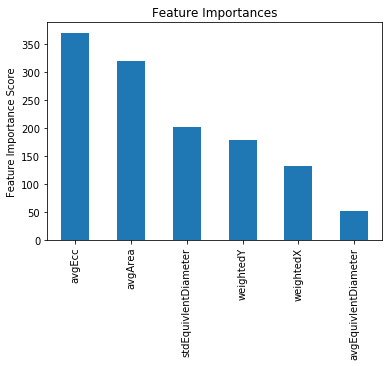

In [105]:
predictors = [x for x in train.columns if x not in [target, idcol, scan_folder]]
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1.0,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)

In [79]:
df = test
df = df.drop('id', 1)
df = df.drop('scan_folder', 1)

In [80]:
xgtest = xgb.DMatrix(df[predictors].values)

In [81]:
preds = xgb1.predict_proba(df)

In [82]:
preds

array([[ 0.74747342,  0.25252658],
       [ 0.7231012 ,  0.2768988 ],
       [ 0.78434497,  0.21565503],
       [ 0.60824788,  0.39175209],
       [ 0.71428573,  0.28571424],
       [ 0.75767958,  0.24232043],
       [ 0.64138103,  0.358619  ],
       [ 0.74747342,  0.25252658],
       [ 0.77753353,  0.22246644],
       [ 0.76950496,  0.23049502],
       [ 0.78868973,  0.21131024],
       [ 0.75621605,  0.24378397],
       [ 0.7231012 ,  0.2768988 ],
       [ 0.75767958,  0.24232043],
       [ 0.74893999,  0.25106004],
       [ 0.77753353,  0.22246644],
       [ 0.77753353,  0.22246644],
       [ 0.71428573,  0.28571424],
       [ 0.71643972,  0.28356031],
       [ 0.77236623,  0.22763377],
       [ 0.76950496,  0.23049502],
       [ 0.71428573,  0.28571424],
       [ 0.78434497,  0.21565503],
       [ 0.77236623,  0.22763377],
       [ 0.71577579,  0.28422421],
       [ 0.64138103,  0.358619  ],
       [ 0.72210449,  0.27789551],
       [ 0.71428573,  0.28571424],
       [ 0.80756354,

In [110]:
data = []
cols = ['id', 'cancer']
df = test
for i, row in tqdm(df.iterrows(), total=len(df)):
    scan_folder = row['scan_folder']
    cancer = preds[i][0]
    t = {
         'id': scan_folder,
         'cancer': cancer
        }
    data.append(t)
df_sub = pd.DataFrame(data)
df_sub = df_sub[cols]
now = datetime.datetime.now()
print now
sub_fname = working_path+'cache/submissions/my_sub_%s.csv' % now
df_sub.to_csv(sub_fname, sep=',', index=False)
print 'Done'
print sub_fname

100%|██████████| 198/198 [00:00<00:00, 4751.28it/s]

2017-03-31 18:23:39.170185
Done
/home/watts/lal/Kaggle/lung_cancer/cache/submissions/my_sub_2017-03-31 18:23:39.170185.csv


In [ ]:
#Random Forest
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
y_pred_prob = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
print ('Random Forest')
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred_prob))


In [ ]:
#XGBoost
print ("XGBoost")
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
y_pred_prob = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=3 )
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
    y_pred_prob[test] = clf.predict_proba(X_test)[:,1]
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred_prob))


In [ ]:
# All Cancer
print "Predicting all positive"
y_pred = np.ones(Y.shape)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))
# No Cancer
print "Predicting all negative"
y_pred = Y*0
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))